# Using a Deep Neural Network for Quark Tagging

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PhysData/course/blob/main/docs/notebooks/tabular_dnn.ipynb)

If you're running this in Colab, make sure to save a copy of the notebook in Google Drive to save your changes.

In this notebook, we're going to explore the use of Deep Neural Networks (DNN) in particle physics, particularly in the task of quark tagging. The goal of this notebook is to create a simple model that can classify whether a jet represents a top-quark signal or a quark-gluon background.

The dataset used in this notebook is the open-source [Top Quark Tagging](https://huggingface.co/datasets/dl4phys/top_tagging) dataset produced from simulations of proton-proton collisions.

In [1]:
# If you're running this notebook, uncomment the code in this cell to install the required packages.
# ! pip install fastai
# ! pip install scikit-learn
# ! pip install scipy
# ! pip install datasets

In [1]:
from datasets import load_dataset
from fastai.tabular.all import *
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score, auc, roc_curve

## Downloading the dataset

First, let's download and inspect the dataset.

In [ ]:
# If you're running this in Colab, uncomment the next line to download the dataset.
top_tagging_ds = load_dataset("dl4phys/top_tagging")

This dataset contains simulated events of proton-proton collisions clustered into jets. Each jet is numbered with an integer subscript and there are 4 data points for each jet labelled `E`, `PX`, `PY`, and `PZ`, corresponding to the four momentum defined as $p = (E, p_x, p_y, p_z)$, where $E$ is the energy of the jet and $p_x, p_y, p_z$ are the components of the jet's momentum in three (orthogonal) spatial directions. 

The dataset also contains the truth value of top-quark 4-momentum, labelled as `truthE`, `truthPX`, `truthPY`, `truthPZ`. Lastly, it also contains the `ttv` flag which is meant to differentiate between train, test, and validation sets (discussed in the primer on machine learning), and a `is_signal_new` flag, indicating whether that particular jet represents a top-quark signal or a quark-gluon background.

In [3]:
top_tagging_ds

DatasetDict({
    train: Dataset({
        features: ['E_0', 'PX_0', 'PY_0', 'PZ_0', 'E_1', 'PX_1', 'PY_1', 'PZ_1', 'E_2', 'PX_2', 'PY_2', 'PZ_2', 'E_3', 'PX_3', 'PY_3', 'PZ_3', 'E_4', 'PX_4', 'PY_4', 'PZ_4', 'E_5', 'PX_5', 'PY_5', 'PZ_5', 'E_6', 'PX_6', 'PY_6', 'PZ_6', 'E_7', 'PX_7', 'PY_7', 'PZ_7', 'E_8', 'PX_8', 'PY_8', 'PZ_8', 'E_9', 'PX_9', 'PY_9', 'PZ_9', 'E_10', 'PX_10', 'PY_10', 'PZ_10', 'E_11', 'PX_11', 'PY_11', 'PZ_11', 'E_12', 'PX_12', 'PY_12', 'PZ_12', 'E_13', 'PX_13', 'PY_13', 'PZ_13', 'E_14', 'PX_14', 'PY_14', 'PZ_14', 'E_15', 'PX_15', 'PY_15', 'PZ_15', 'E_16', 'PX_16', 'PY_16', 'PZ_16', 'E_17', 'PX_17', 'PY_17', 'PZ_17', 'E_18', 'PX_18', 'PY_18', 'PZ_18', 'E_19', 'PX_19', 'PY_19', 'PZ_19', 'E_20', 'PX_20', 'PY_20', 'PZ_20', 'E_21', 'PX_21', 'PY_21', 'PZ_21', 'E_22', 'PX_22', 'PY_22', 'PZ_22', 'E_23', 'PX_23', 'PY_23', 'PZ_23', 'E_24', 'PX_24', 'PY_24', 'PZ_24', 'E_25', 'PX_25', 'PY_25', 'PZ_25', 'E_26', 'PX_26', 'PY_26', 'PZ_26', 'E_27', 'PX_27', 'PY_27', 'PZ_27', 'E_28'

In [4]:
top_tagging_ds["train"]

Dataset({
    features: ['E_0', 'PX_0', 'PY_0', 'PZ_0', 'E_1', 'PX_1', 'PY_1', 'PZ_1', 'E_2', 'PX_2', 'PY_2', 'PZ_2', 'E_3', 'PX_3', 'PY_3', 'PZ_3', 'E_4', 'PX_4', 'PY_4', 'PZ_4', 'E_5', 'PX_5', 'PY_5', 'PZ_5', 'E_6', 'PX_6', 'PY_6', 'PZ_6', 'E_7', 'PX_7', 'PY_7', 'PZ_7', 'E_8', 'PX_8', 'PY_8', 'PZ_8', 'E_9', 'PX_9', 'PY_9', 'PZ_9', 'E_10', 'PX_10', 'PY_10', 'PZ_10', 'E_11', 'PX_11', 'PY_11', 'PZ_11', 'E_12', 'PX_12', 'PY_12', 'PZ_12', 'E_13', 'PX_13', 'PY_13', 'PZ_13', 'E_14', 'PX_14', 'PY_14', 'PZ_14', 'E_15', 'PX_15', 'PY_15', 'PZ_15', 'E_16', 'PX_16', 'PY_16', 'PZ_16', 'E_17', 'PX_17', 'PY_17', 'PZ_17', 'E_18', 'PX_18', 'PY_18', 'PZ_18', 'E_19', 'PX_19', 'PY_19', 'PZ_19', 'E_20', 'PX_20', 'PY_20', 'PZ_20', 'E_21', 'PX_21', 'PY_21', 'PZ_21', 'E_22', 'PX_22', 'PY_22', 'PZ_22', 'E_23', 'PX_23', 'PY_23', 'PZ_23', 'E_24', 'PX_24', 'PY_24', 'PZ_24', 'E_25', 'PX_25', 'PY_25', 'PZ_25', 'E_26', 'PX_26', 'PY_26', 'PZ_26', 'E_27', 'PX_27', 'PY_27', 'PZ_27', 'E_28', 'PX_28', 'PY_28', 'PZ_28', 

In [5]:
len(top_tagging_ds["train"])

1211000

In [6]:
# Remove data irrelevant to our classification task
top_tagging_ds = top_tagging_ds.remove_columns(
    ["truthE", "truthPX", "truthPY", "truthPZ", "ttv"]
)

You may have noticed that inspecting the dataset in this form is quite cumbersome. To make life easier, we're going to load our data into the `DataFrame` format provided by the pandas library, which is going to allow us to view this dataset in a more legible format.

In [7]:
# Convert output format to DataFrames
top_tagging_ds.set_format("pandas")
# Create DataFrames for the training and test splits
train_df, test_df = top_tagging_ds["train"][:], top_tagging_ds["test"][:]
# Peek at first few rows
# train_df.head()

In [8]:
train_df.shape

(1211000, 801)

Let's print out the first few rows and columns of this dataset.

In [9]:
train_df_subset = train_df.T[0:5].T
test_df_subset = test_df.T[0:5].T
train_df_subset.head()

,E_0,PX_0,PY_0,PZ_0,E_1
0,474.071136,-250.347031,-223.651962,-334.738098,103.236237
1,150.504532,120.062393,76.852005,-48.274265,82.257057
2,251.645386,10.427651,-147.573746,203.564880,104.147797
3,451.566132,129.885437,-99.066292,-420.984100,208.410919
4,399.093903,-168.432083,-47.205597,-358.717438,273.691956


## FastAI DataLoaders

FastAI is a library for manipulating data and building AI models. You don't need a thorough understanding of this library to appreciate the use of AI for this particular task, but we highly encourage interested readers to explore further.

In the next cell, we're going to use a `DataLoader` to load our dataset to the fastai format. This will do a number of important things for us like batch splitting, an important part of data preprocessing in machine learning tasks.

In essence, our model is going to receive "batches" of training data that have just the right size so that they can fit into our computer memory. It wouldn't make sense to pass the entire dataset to our model all at once, simply because the dataset might be too large. By creating batches, we can take advantage of parallel processing units (such as those in GPUs) as well as shuffle our data around so that the model needs to learn from sparse samples at each given iteration.

In [16]:
frac_of_samples = 1.0
train_df = train_df.sample(int(frac_of_samples * len(train_df)), random_state=40)

features = list(train_df.drop(columns=["is_signal_new"]).columns)
# features = list(train_df.columns)
splits = RandomSplitter(valid_pct=0.20, seed=42)(range_of(train_df))

dls = TabularDataLoaders.from_df(
    df=train_df,
    cont_names=features,
    y_names="is_signal_new",
    y_block=CategoryBlock,
    splits=splits,
    bs=1024,
)

## The Deep Neural Network Model

In this section, we define the neural network using the `tabular_learner` function from FastAI. You can see the individual layers and their sizes below `learn.summary()`.

In [17]:
learn = tabular_learner(
    dls, layers=[200, 200, 50, 50], metrics=[accuracy, RocAucBinary()]
)

The `tabular_learner` creates a deep neural network (DNN) with the layers specified according to the function parameters. Here we are building a network with 4 layers with the following number of nodes: 200, 200, 50, 50 respectively. We also specify that with this model, we are interested in its accuracy (i.e. how accurate is it at predicting a given jet represents a top-quark or a quark-gluon) and the metric to measure the accuracy is `RocAucBinary`. `RocAucBinary` is used for binary classification tasks such as this one and it is a measure of sensitivity of the true and false positive rate of prediction. For more information, see the following [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score).

In [18]:
learn.summary()

TabularModel (Input shape: 1024 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 800          
BatchNorm1d                               1600       True      
____________________________________________________________________________
                     1024 x 200          
Linear                                    160000     True      
ReLU                                                           
BatchNorm1d                               400        True      
Linear                                    40000      True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     1024 x 50           
Linear                                    10000      True      
ReLU                                                           
BatchNorm1d                               1

## Finding learning rate

The learning rate sets the relative size of the learning steps that the model is taking during training, i.e. how much are the model's internal parameters changed every time it gets feedback on its predictions.

SuggestedLRs(valley=0.0006918309954926372)

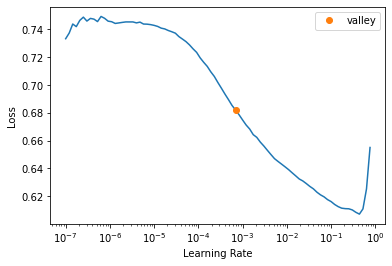

In [19]:
learn.lr_find()

## Training the model

Here we're going to run one training cycle which is going to go through all the training data. If you're running this notebook youself, consider changing the number of epochs or learning rate.

In [20]:
learn.fit_one_cycle(n_epoch=3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.518409,0.515188,0.732680,0.802404,00:16
1,0.432351,0.417070,0.804059,0.884536,00:16
2,0.389154,0.379476,0.827023,0.904105,00:15


In [17]:
# You can inspect the results by uncommenting the following line
# learn.show_results()

## Model Evaluation

Now that we've trained our model for one cycle, we can use it to make predictions on data it has not seen before. For this, we're going to use the `test_df` object we defined above.

In [21]:
test_dl = learn.dls.test_dl(test_items=test_df)

In [22]:
# get predictions and targets (the real values) by running the test data through our trained model
preds, targs = learn.get_preds(dl=test_dl)

In [23]:
preds[:5], targs[:5]

(tensor([[0.9982, 0.0018],
         [0.4272, 0.5728],
         [0.7789, 0.2211],
         [0.3957, 0.6043],
         [0.9867, 0.0133]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0]], dtype=torch.int8))

As can be seen above, even though we're looking for binary decisions, our model makes probabilistic estimates about the likelihood of each signal being either a top-quark or a quark-gluon background. To decide whether a given prediction represents a top-quark or a quark-gluon background, we can set a cut-off threshold on the individual probabilities.

Let's plot the probabilities per events to see how our predictions vary in light of the ground truth classifications.

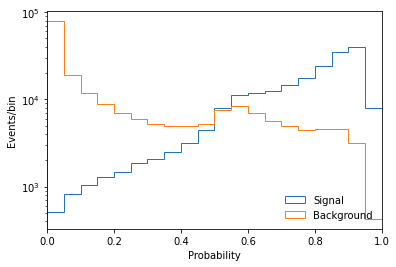

In [24]:
signal_test = preds[:, 1][targs.flatten() == 1].numpy()
background_test = preds[:, 1][targs.flatten() == 0].numpy()

plt.hist(signal_test, histtype="step", bins=20, range=(0, 1), label="Signal")
plt.hist(background_test, histtype="step", bins=20, range=(0, 1), label="Background")
plt.xlabel("Probability")
plt.ylabel("Events/bin")
plt.yscale("log")
plt.xlim(0, 1)
plt.legend(loc="lower right", frameon=False)
plt.show()

The accuracy of a binary classifier can be better understood as the relation between the False Positive classification rate and the True Positive classification rate. This relationship is described by the Reciever Operating Characteristic curve (ROC). With the ROC curve, we can measure the effectiveness of our model by looking at the area under the curve (AUC). Higher values of the AUC mean better prediction capability of our model (1 is the highest).

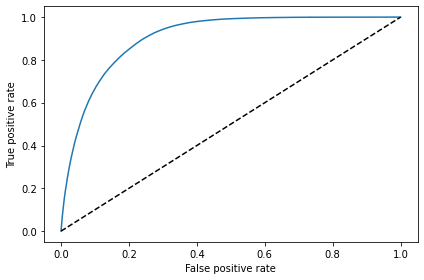

In [25]:
fpr, tpr, thresholds = roc_curve(y_true=targs, y_score=preds[:, 1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], ls="--", color="k")
plt.xlabel(r"False positive rate")
plt.ylabel(r"True positive rate")
plt.tight_layout()

In [26]:
acc_test = accuracy_score(targs, preds.argmax(dim=-1))
auc_test = auc(fpr, tpr)
print(f"Accuracy: {acc_test:.4f}")
print(f"AUC: {auc_test:.4f}")

Accuracy: 0.8278
AUC: 0.9048


We can see that after one training cycle with 3 epochs, we've reached a test accuracy of ~83%. Think about how you can improve on this result in your own experimentation. Some things to experiment with:
* Model architecture: try changing the size of each layer and the number of layers in the `tabular_learner`. What do you observe? Does a bigger model always mean better results?
* Fit more cycles: Does training for a longer period of time produce better results?

This concludes our short exploration of the use of Deep Neural Networks in particle physics.

This notebook was adapted based on material from the course **Deep Learning for Particle Physicists**, avaialable at https://lewtun.github.io/dl4phys/intro.html.

## References

* [HuggingFace Top Tagging Dataset](https://huggingface.co/datasets/dl4phys/top_tagging)
* [Pandas library](https://pandas.pydata.org/)
* [FastAI](https://www.fast.ai/)
* [Receiver Operating Characteristic Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
* [Deep Learning for Particle Physicists](https://lewtun.github.io/dl4phys/intro.html)

If you wish to get an overview of the remaining topics in this course, click the button below.

[![Back to main website](../media/back4.png)](https://physdata.vercel.app/)